# 3.0a Cluster Analysis with Taxi Main DF

**Tasks**: Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods**: Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.
Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

## Outline of this notebook:
1. Helper Functions
2. Adding Additional Features
3. Feature Selection
4. ...

In [1]:
# Hexagon resolution to work with for the rest of the notebook
RES = 8

In [2]:
# Standard libraries - run pip install if necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from datetime import datetime

# Geospatial libraries
from h3 import h3 
import geopandas as gp
import folium
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
## Color for map 
import branca
import branca.colormap as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

# progress bar
from tqdm import tqdm
tqdm.pandas()

In [304]:
# Color palette
colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
# Set a global color palette
sns.set_palette(['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252'])

In [152]:
taxi_df = pd.read_csv("data/prepped/prep_taxidata.csv")

In [153]:
taxi_df.head(3)

,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,company_encoded,taxi_id_encoded,pickup_community,pickup_area_number,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff
0,0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31 23:45:00,2023-01-01 00:15:00,2081.0,4.42,NaN,NaN,20.50,...,0,0,WEST RIDGE,2,UPTOWN,3,872664d8effffff,872664d89ffffff,882664d8e1fffff,882664d897fffff
1,1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,13.84,...,0,1,NEAR NORTH SIDE,8,WEST TOWN,24,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff
2,2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31 23:45:00,2023-01-01 00:00:00,600.0,0.90,NaN,NaN,7.00,...,1,2,NEAR NORTH SIDE,8,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff


In [5]:
taxi_df.isna().sum()

Unnamed: 0                          0
trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           2884556
dropoff_census_tract          2884556
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude            0
pickup_centroid_longitude           0
pickup_centroid_location            0
dropoff_centroid_latitude           0
dropoff_centroid_longitude          0
dropoff_centroid_location           0
trip_hours                          0
1_hour_window                       0
1_hour_window_sin                   0
1_hour_window_cos                   0
4_hour_windo

In [6]:
pd.to_numeric(taxi_df["pickup_area_number"], downcast='integer')
pd.to_numeric(taxi_df["dropoff_area_number"], downcast='integer')

0           3
1          24
2           8
3           8
4           8
           ..
5320304    22
5320305    32
5320306    77
5320307     3
5320308     8
Name: dropoff_area_number, Length: 5320309, dtype: int8

In [7]:
# Check main df, if any big outliers still (comparing means) 
taxi_df.describe()

,Unnamed: 0,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,tolls,extras,trip_total,...,6_hour_window_sin,6_hour_window_cos,weekday,weekday_sin,weekday_cos,payment_type_encoded,company_encoded,taxi_id_encoded,pickup_area_number,dropoff_area_number
count,5.320309e+06,5.320309e+06,5.320309e+06,2.435753e+06,2.435753e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,...,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06,5.320309e+06
mean,3.185513e+06,1.096465e+03,5.370159e+00,1.703145e+10,1.703141e+10,1.931889e+01,2.398395e+00,1.364020e-03,1.096509e+00,2.296482e+01,...,-1.776307e-02,-3.434613e-01,2.881805e+00,5.711463e-02,-5.509035e-02,2.052332e+00,4.440882e+00,1.304573e+03,3.053719e+01,2.591548e+01
std,1.844741e+06,9.088033e+02,6.146649e+00,3.625628e+05,3.441342e+05,1.472827e+01,3.351792e+00,8.435670e-02,2.707011e+00,1.792594e+01,...,7.312071e-01,5.891139e-01,1.902813e+00,6.969205e-01,7.127447e-01,1.050919e+00,5.541477e+00,7.862590e+02,2.416608e+01,2.099785e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,1.703101e+10,1.703101e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.000000e+00,-1.000000e+00,0.000000e+00,-9.749279e-01,-9.009689e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,1.583122e+06,4.570000e+02,8.600000e-01,1.703108e+10,1.703108e+10,7.750000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.750000e+00,...,-1.000000e+00,-1.000000e+00,1.000000e+00,-4.338837e-01,-9.009689e-01,1.000000e+00,1.000000e+00,6.340000e+02,8.000000e+00,8.000000e+00
50%,3.183302e+06,8.070000e+02,2.220000e+00,1.703132e+10,1.703132e+10,1.232000e+01,9.200000e-01,0.000000e+00,0.000000e+00,1.500000e+01,...,1.224647e-16,-1.836970e-16,3.000000e+00,0.000000e+00,-2.225209e-01,2.000000e+00,3.000000e+00,1.257000e+03,2.800000e+01,2.800000e+01
75%,4.786210e+06,1.504000e+03,9.360000e+00,1.703184e+10,1.703184e+10,3.000000e+01,3.190000e+00,0.000000e+00,1.000000e+00,3.125000e+01,...,1.000000e+00,6.123234e-17,4.000000e+00,7.818315e-01,6.234898e-01,3.000000e+00,7.000000e+00,1.959000e+03,3.600000e+01,3.200000e+01
max,6.382424e+06,1.131100e+04,3.017000e+01,1.703198e+10,1.703198e+10,1.680000e+02,1.501000e+01,2.300000e+01,6.750000e+01,1.800000e+02,...,1.000000e+00,1.000000e+00,6.000000e+00,9.749279e-01,1.000000e+00,7.000000e+00,3.600000e+01,2.937000e+03,7.700000e+01,7.700000e+01


## 1.0 Helper functions

In [187]:
# Feature Selection according to https://medium.com/analytics-vidhya/k-means-algorithm-in-4-parts-4-4-42bc6c781e46
def optimize_feature_selection(df_test_sample, maxvars=8, kmin=2, kmax=6):
    '''
    
    Input is sampled df (approx.  rows, else takes too long)
    Maximal number of variables we want to have 
    Minimum and maximum number of clusters for which we calculate the silhouette scores
    
    Returns the best cluster number and the most suitable variables for clustering
    
    '''
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_test_sample)
    
    results_for_each_k = []
    vars_for_each_k = {}
    
    for k in tqdm(range(kmin, kmax + 1), desc="Clusters"):
        cols = list(df_test_sample.columns)
        selected_variables = []
        
        for _ in tqdm(range(maxvars), desc=f"Variables for k={k}", leave=False):
            results = []
            for col in cols:
                scols = selected_variables + [col]
                kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
                kmeans.fit(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in scols]])
                
                # Silhouette score can only be calculated if more than 1 label, hence append -1 score if clustering yielded <= 1
                unique_labels = np.unique(kmeans.labels_)
                if len(unique_labels) > 1:
                    score = silhouette_score(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in scols]], 
                                             kmeans.labels_)
                    results.append(score)
                else:
                    results.append(-1) 
            
            selected_var = cols[np.argmax(results)]
            selected_variables.append(selected_var)
            cols.remove(selected_var)
        
        results_for_each_k.append(max(results))
        vars_for_each_k[k] = selected_variables
    
    best_k = np.argmax(results_for_each_k) + kmin
    selected_variables = vars_for_each_k[best_k]
    
    kmeans = KMeans(n_clusters=best_k,  n_init="auto", random_state=42)
    kmeans.fit(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in selected_variables]])
    #clusters = kmeans.predict(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in selected_variables]])
    
    return best_k, selected_variables #clusters

In [8]:
# Scaling
def scale_df(X):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(X)
    return pd.DataFrame(df_scaled, columns=X.columns, index=X.index)

In [10]:
# Dimensionality Reduction via PCA
def number_of_componentsPCA(X_scaled):
    pca = PCA()
    pca.fit(X_scaled)
    per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)

    plt.figure(figsize = (8,6))
    plt.plot(range(1, len(per_var)+1), per_var.cumsum(), marker = "o", linestyle = "--", color="g")
    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    
    plt.axhline(y=90, color='r', linestyle='-')
    
    plt.ylabel("Percentage Cumulative of Explained Variance")
    plt.xlabel("Number of Components")
    plt.title("Explained Variance by Component")
    plt.show()

In [11]:
# Perform PCA 
def do_pca(X_scaled, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(X_scaled)
    return pca.transform(X_scaled)

In [12]:
# Heatmap for feature selection
def heatmap(scaled_dataframe, x, y):
    corr_matrix = scaled_dataframe.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=(x, y))
    sns.heatmap(corr_matrix,
            mask = mask,
            annot=True, 
            cmap='GnBu', 
            vmin=0, 
            vmax=1,
            linewidth=1, linecolor="w", square=True
           )
    plt.title('Feature Importances using Correlation-Matrix')
    plt.show()

In [13]:
# Grid search
def elbow_method(df_scaled, max_clusters=10):
    loss = []
    for k in tqdm(range(1, max_clusters+1)):
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(df_scaled)
        loss.append(km.inertia_)

    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    plt.plot(range(1, max_clusters+1), loss, marker='o', linestyle='--')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS Loss')
    plt.title('Elbow Method with K-Means++')
    plt.show()

In [14]:
# Silhouette scores according to different cluster numbers
def plot_silhouette_scores(data, k_max):
    # 10000 rows only since computationally expensive else
    df_sampled = data.sample(n=10000, random_state=42)
    
    ncols = 3
    # calculate number of rows
    nrows = k_max // ncols + (k_max % ncols > 0)
    fig = plt.figure(figsize=(15,15), dpi=200)
    
    for k in tqdm(range(2, k_max+1)):
        km = KMeans(init='k-means++', n_clusters=k, n_init=10, random_state=42)
        km_fit = km.fit(df_sampled)
    
        # Visualize
        ax = plt.subplot(nrows, ncols, k-1)
        silhouette_plot(df_sampled, km_fit, ax)
    
    fig.suptitle("Silhouette plots", fontsize=18, y=1)
    plt.tight_layout()
    plt.show()

In [147]:
# Silhouette Plot for (works only for small sample else too computationally expensive!)
# Medium Best Practices for Visualizing Your Cluster Results
def silhouette_plot(X, model, ax):
    y_lower = 10
    y_tick_pos_ = []
    sh_samples = silhouette_samples(X, model.labels_)
    sh_score = silhouette_score(X, model.labels_)
    
    for idx in range(model.n_clusters):
        values = sh_samples[model.labels_ == idx]
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, values, facecolor=colors[idx],edgecolor=colors[idx])
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 10

    ax.axvline(x=sh_score, color="red", linestyle="--", label="Avg Silhouette Score")
    ax.set_title("Silhouette Plot for {} clusters".format(model.n_clusters))
    l_xlim = max(-1, min(-0.1, round(min(sh_samples) - 0.1, 1)))
    u_xlim = min(1, round(max(sh_samples) + 0.1, 1))
    ax.set_xlim([l_xlim, u_xlim])
    ax.set_ylim([0, X.shape[0] + (model.n_clusters + 1) * 10])
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(model.n_clusters))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.legend(loc="best")
    return ax

Silhouette Score measures goodness of fit for different cluster numbers by (b-a)/max(a,b) where:
- b: average distance between all clusters
- a: average distance between each point within a cluster

The score is between [-1, 1], where
- -1 means clusters are assigned wrong
- 1 means clusters are well apart 
- 0 means cluster distance is not significant

(https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

In [318]:
# Visualize cluster representation by plotting magnitude and cardinality of clusters
def visualize_cluster_representative_power(n_clusters, df, cluster_labels, cluster_centers, df_scaled):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Plot cluster cardinality
    cluster_cardinality = [np.sum(df[cluster_labels] == i) for i in range(n_clusters)]
    average_cardinality = np.mean(cluster_cardinality)

    sns.barplot(x=list(range(n_clusters)), y=cluster_cardinality, ax=axes[0, 0], hue=list(range(n_clusters)), palette=custom_palette[:n_clusters])
    axes[0, 0].set_title('Cluster Cardinality')
    axes[0, 0].set_xlabel('Cluster Label')
    axes[0, 0].set_ylabel('Points in Cluster')
    axes[0, 0].axhline(average_cardinality, color='red', linestyle='--', label=f'Average Cardinality of a Cluster is: {average_cardinality:.0f}')
    axes[0, 0].legend()
    
    # 2. Plot cluster magnitudes
    cluster_magnitudes = []
    for i in range(n_clusters):
        points_in_cluster = df_scaled[df[cluster_labels] == i]
        centroid = cluster_centers[i]
        magnitude = np.sum(np.linalg.norm(points_in_cluster - centroid, axis=1))
        cluster_magnitudes.append(magnitude)
        
    sns.barplot(x=list(range(n_clusters)), y=cluster_magnitudes, ax=axes[0, 1], hue=list(range(n_clusters)), palette=custom_palette[:n_clusters])
    axes[0, 1].set_title('Cluster Magnitude')
    axes[0, 1].set_xlabel('Cluster Label')
    axes[0, 1].set_ylabel('Total Point-to-Centroid Distance')
    
    # 3. Plot magnitude vs. cardinality
    colors = sns.color_palette("husl", n_clusters)  # Generating a color palette
    axes[1, 0].scatter(cluster_cardinality, cluster_magnitudes, color=colors)
    for i in range(n_clusters):
        axes[1, 0].text(cluster_cardinality[i], cluster_magnitudes[i], str(i))
    axes[1, 0].plot(cluster_cardinality, cluster_magnitudes, color='blue')
    axes[1, 0].set_title('Magnitude vs. Cardinality')
    axes[1, 0].set_xlabel('Cardinality')
    axes[1, 0].set_ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()

After clustering with the determined optimal number of clusters has been applied, you should have a look at the cluster results.
It is very useful to focus on properties such as:
- Cluster Cardinality: The cluster cardinality, or the cluster sizes, plot shows the number of points per cluster
- Cluster Magnitude: shows the total point to centroid distance per cluster. This chart can be used to see how high is the ‘spread’ of the points in each cluster and if there are any clumpy or wide clusters
- Magnitude vs. Cardinality: compares cluster cardinality with cluster magnitude. Clusters with a higher cardinality tend to also have a higher cluster magnitude. The idea is that normal clusters lie on or are very close to the 45-degree line. Anomalies tend to lie more distant from it. In our example cluster 1 is anomalous.

## 2.0 Adding Additional Features 
You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.

### 2.0.1 Temporal Features

In [154]:
taxi_df["trip_start_timestamp"] = pd.to_datetime(taxi_df["trip_start_timestamp"])
taxi_df["trip_end_timestamp"] = pd.to_datetime(taxi_df["trip_end_timestamp"])

In [155]:
# Get start & end hour of each entry
taxi_df["start_hour"] = taxi_df['trip_start_timestamp'].dt.hour
taxi_df["end_hour"] = taxi_df['trip_end_timestamp'].dt.hour

# 6:00 AM to 9:00 AM
taxi_df['morning_commute'] = ((taxi_df['start_hour'] >= 6) & (taxi_df['start_hour'] < 9)).astype(int)

# 9:00 AM to 12:00 PM
taxi_df['late_morning'] = ((taxi_df['start_hour'] >= 9) & (taxi_df['start_hour'] < 12)).astype(int)

# 12:00 PM to 4:00 PM
taxi_df['afternoon'] = ((taxi_df['start_hour'] >= 12) & (taxi_df['start_hour'] < 16)).astype(int)

# 4:00 PM to 8:00 PM (Chicago rush hour times)
taxi_df['evening_commute'] = ((taxi_df['start_hour'] >= 16) & (taxi_df['start_hour'] < 20)).astype(int)

# 8:00 PM to 6:00 AM
taxi_df['night'] = ((taxi_df['start_hour'] >= 20) | (taxi_df['start_hour'] < 6)).astype(int)

In [156]:
# Get weekday or not (0 if not, 1 if it is)
taxi_df['is_weekday'] = (taxi_df["weekday"] < 5).astype(int)

### 2.0.2 Distance to city center

In [165]:
# City center = hexagon with the most pickups
center_hex = taxi_df[f'h3_res{RES}_pickup'].value_counts().idxmax()

print(f'Center hexagon: {center_hex}')
taxi_df[taxi_df[f'h3_res{RES}_pickup'] == center_hex].iloc[0].pickup_community

Center hexagon: 882664c1edfffff


'NEAR NORTH SIDE'

In [166]:
# Calculate grid distances
def calculate_h3_grid_distances(df, center_hex):
    df[f'dist_from_center_pickup'] = df[f'h3_res{RES}_pickup'].apply(lambda x: h3.h3_distance(x, center_hex))
    df[f'dist_from_center_dropoff'] = df[f'h3_res{RES}_dropoff'].apply(lambda x: h3.h3_distance(x, center_hex))
    
    return df

In [167]:
taxi_df = calculate_h3_grid_distances(taxi_df, center_hex)

### 2.0.3 Trip Direction

If we are moving towards the center, then the direction (distance between pickup and dropoff) is positive, whereas moving away from the city center gives us a negative distance

In [168]:
# Get the direction of the trip
taxi_df['moving_towards_center'] = taxi_df['dist_from_center_pickup'] - taxi_df['dist_from_center_dropoff'] 

In [169]:
taxi_df[taxi_df['moving_towards_center'] < 0].head(3)

,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,end_hour,morning_commute,late_morning,afternoon,evening_commute,night,is_weekday,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center
1,1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,13.84,...,0,0,0,0,0,1,0,0,4,-4
6,6,32c54ad25f76c07b29bc59b04f9f196cf811ed67,cb1a522e6e968cbebb7ce23e6775a4769de4aeb2154fa5...,2022-12-31 23:45:00,2023-01-01 00:00:00,876.0,8.91,NaN,NaN,23.75,...,0,0,0,0,0,1,0,6,23,-17
7,8,3186be22cdd5d17def50e44eca6be9ec9b0a9974,4f78222d267c08ee7267810e5f3f2241dc61bf1396d036...,2022-12-31 23:45:00,2022-12-31 23:45:00,540.0,0.70,1.703108e+10,1.703184e+10,7.25,...,23,0,0,0,0,1,0,2,3,-1


### 2.0.4 Drop redundant columns

Now we want to drop any columns that are trivial to the clustering process, since either the columns are available in another form, or they are not analysed at all. For instance, columns trid_id, company and payment_type have now a respective encoded column, the trip start time has been discretized into more granular columns and the end time is not analysed. 
Furthermore, columns for geographical information can be dropped too as we have corresponding h3 columns that summarize most important information. 

In [170]:
taxi_df.columns

Index(['Unnamed: 0', 'trip_id', 'taxi_id', 'trip_start_timestamp',
       'trip_end_timestamp', 'trip_seconds', 'trip_miles',
       'pickup_census_tract', 'dropoff_census_tract', 'fare', 'tips', 'tolls',
       'extras', 'trip_total', 'payment_type', 'company',
       'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude',
       'dropoff_centroid_longitude', 'dropoff_centroid_location', 'trip_hours',
       '1_hour_window', '1_hour_window_sin', '1_hour_window_cos',
       '4_hour_window', '4_hour_window_sin', '4_hour_window_cos',
       '6_hour_window', '6_hour_window_sin', '6_hour_window_cos', 'weekday',
       'weekday_sin', 'weekday_cos', 'payment_type_encoded', 'company_encoded',
       'taxi_id_encoded', 'pickup_community', 'pickup_area_number',
       'dropoff_community', 'dropoff_area_number', 'h3_res7_pickup',
       'h3_res7_dropoff', 'h3_res8_pickup', 'h3_res8_dropoff', 'start_hour',
       'end_hour', 'mornin

In [171]:
# Drop unneeded columns for further steps 
columns_to_drop = ['Unnamed: 0','trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
                   'pickup_census_tract', 'dropoff_census_tract', 
                   'payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff_centroid_location',]
prep_df = taxi_df.drop(columns_to_drop, axis=1)
prep_df.head()

,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,trip_hours,1_hour_window,1_hour_window_sin,...,end_hour,morning_commute,late_morning,afternoon,evening_commute,night,is_weekday,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center
0,2081.0,4.42,20.50,0.00,0.0,0.0,20.50,0.578056,23,-0.258819,...,0,0,0,0,0,1,0,13,8,5
1,812.0,0.00,13.84,2.73,0.0,0.0,16.57,0.225556,23,-0.258819,...,0,0,0,0,0,1,0,0,4,-4
2,600.0,0.90,7.00,2.00,0.0,3.0,12.00,0.166667,23,-0.258819,...,0,0,0,0,0,1,0,0,0,0
3,546.0,0.85,6.50,0.00,0.0,0.0,6.50,0.151667,23,-0.258819,...,0,0,0,0,0,1,0,0,0,0
4,574.0,0.33,6.25,0.00,0.0,0.0,6.25,0.159444,23,-0.258819,...,0,0,0,0,0,1,0,0,0,0


## 3.0 Clustering Temporal Based Features

### 5.1 Feature Selection

To decide on features for which we want to cluster, we thought about task relevant features but also tested around with an algorithm provided by https://medium.com/analytics-vidhya/k-means-algorithm-in-4-parts-4-4-42bc6c781e46. In the end, we decided on
- Temporal features
- Trip-Distance/Geo-Spatial features
- Customer-Behaviour features

In [178]:
prep_df.columns

Index(['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'trip_hours', '1_hour_window', '1_hour_window_sin',
       '1_hour_window_cos', '4_hour_window', '4_hour_window_sin',
       '4_hour_window_cos', '6_hour_window', '6_hour_window_sin',
       '6_hour_window_cos', 'weekday', 'weekday_sin', 'weekday_cos',
       'payment_type_encoded', 'company_encoded', 'taxi_id_encoded',
       'pickup_community', 'pickup_area_number', 'dropoff_community',
       'dropoff_area_number', 'h3_res7_pickup', 'h3_res7_dropoff',
       'h3_res8_pickup', 'h3_res8_dropoff', 'start_hour', 'end_hour',
       'morning_commute', 'late_morning', 'afternoon', 'evening_commute',
       'night', 'is_weekday', 'dist_from_center_pickup',
       'dist_from_center_dropoff', 'moving_towards_center'],
      dtype='object')

In [202]:
non_numerical_or_trivial = [ 
    'trip_hours',
    '1_hour_window', '1_hour_window_sin',
       '1_hour_window_cos', '4_hour_window', '4_hour_window_sin',
       '4_hour_window_cos', '6_hour_window', '6_hour_window_sin',
       '6_hour_window_cos', 'weekday', 'weekday_sin', 'weekday_cos', 'taxi_id_encoded','pickup_community', 'dropoff_community','h3_res7_pickup', 'h3_res7_dropoff',
       'h3_res8_pickup', 'h3_res8_dropoff',
       # redundant with start_hour
       'end_hour',
       'morning_commute', 'late_morning', 'afternoon', 'evening_commute',
       'night',
        # redundant with trip_total 
        'fare', 'tolls', 'extras',         
                           ]
df_fselection = prep_df.drop(non_numerical_or_trivial, axis=1).copy()
df_fselection.shape

(5320309, 13)

In [203]:
df_fselection.columns

Index(['trip_seconds', 'trip_miles', 'tips', 'trip_total',
       'payment_type_encoded', 'company_encoded', 'pickup_area_number',
       'dropoff_area_number', 'start_hour', 'is_weekday',
       'dist_from_center_pickup', 'dist_from_center_dropoff',
       'moving_towards_center'],
      dtype='object')

In [204]:
#all_selected_variables = []
#best_k_all = []
# Tested with limited sample but also repeated to see if anydifference between selected_variables -> No difference found hence commented out
#for i in range(1, 4):
df_test_sample = df_fselection.sample(n=3000, random_state=42)
best_k, selected_variables = optimize_feature_selection(df_test_sample)
    #best_k_all.append(best_k)
    #all_selected_variables.append(selected_variables)
print(f"Best k: {best_k}")
print(f"Selected variables: {selected_variables}")

Variables for k=3:   0%|                                                                         | 0/8 [00:00<?, ?it/s]C:\Users\25mad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Variables for k=4:   0%|                                                                         | 0/8 [00:00<?, ?it/s]C:\Users\25mad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)

Variables for k=5:   0%|                                                                         | 0/8 [00:00<?, ?it/s]C:\Users\25mad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: Converge

Best k: 4
Selected variables: ['is_weekday', 'dist_from_center_pickup', 'pickup_area_number', 'dist_from_center_dropoff', 'moving_towards_center', 'trip_total', 'trip_miles', 'trip_seconds']


In [245]:
#Best k: 4
#Selected variables: ['is_weekday', 'dist_from_center_pickup', 'pickup_area_number', 'dist_from_center_dropoff', 'moving_towards_center', 'trip_total', 'trip_miles', 'trip_seconds']
df_selection = df_fselection[selected_variables]

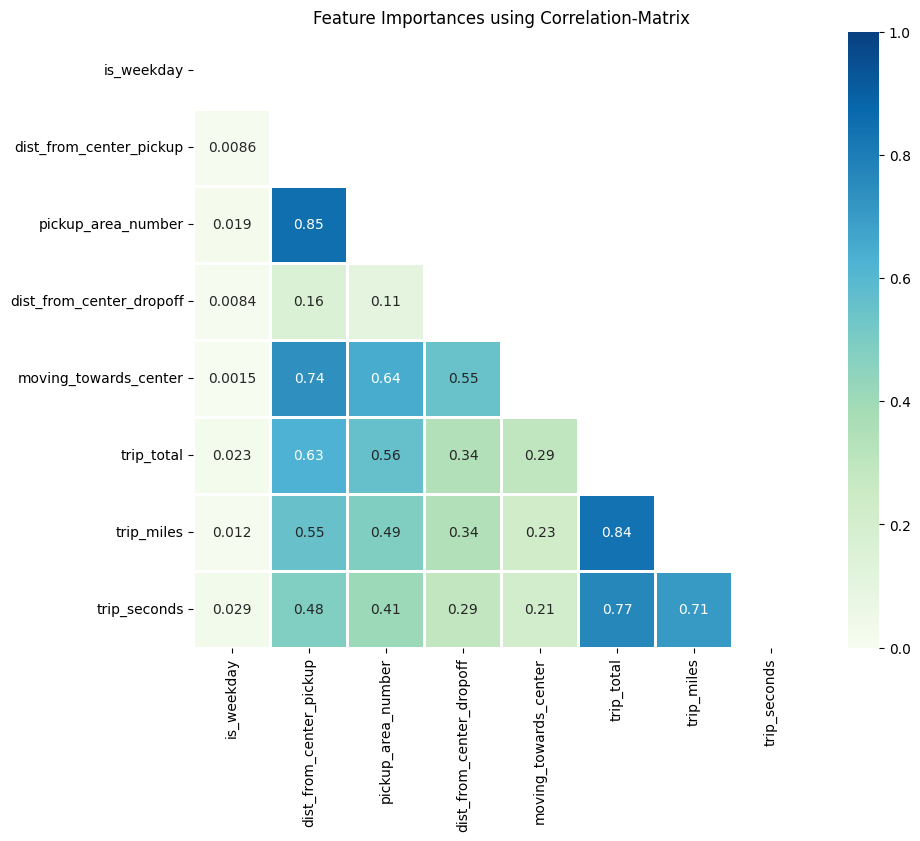

In [246]:
# Visualize correlations between features method has found
heatmap(df_selection, x=10, y=8)

Interesting Observations we can make from this:
- dist_from_center_pickup and trip_total as well as trip_miles
- pickup_area_number has similarly high correlations with trip_totla and trip_miles
- moving_towards_center has high correlation with pickup_area_number

### 3.2 PCA and Number of Clusters

In [247]:
# Scale df
scaler = StandardScaler()
df_selection_scaled = scaler.fit_transform(df_selection)

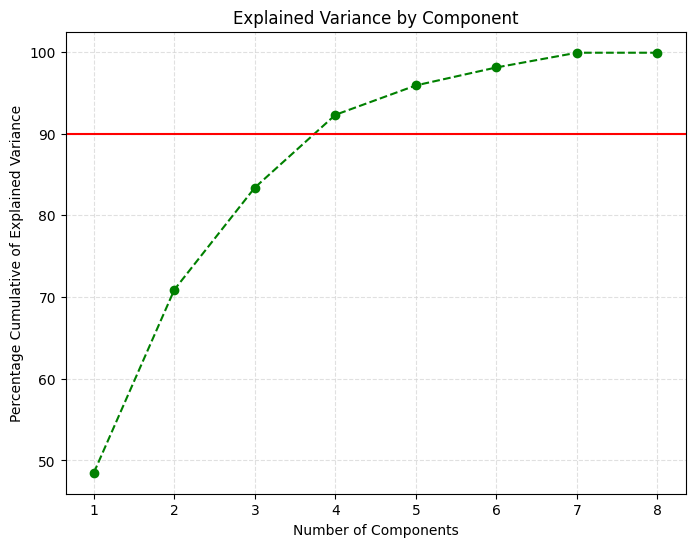

In [248]:
number_of_componentsPCA(df_selection_scaled)

In [249]:
# Additionally reduce dim with PCA
pca_scaling = PCA(n_components=4)
pca_scaling_result = pca_scaling.fit_transform(df_selection_scaled)
explained_variance_scaling = pca_scaling.explained_variance_ratio_

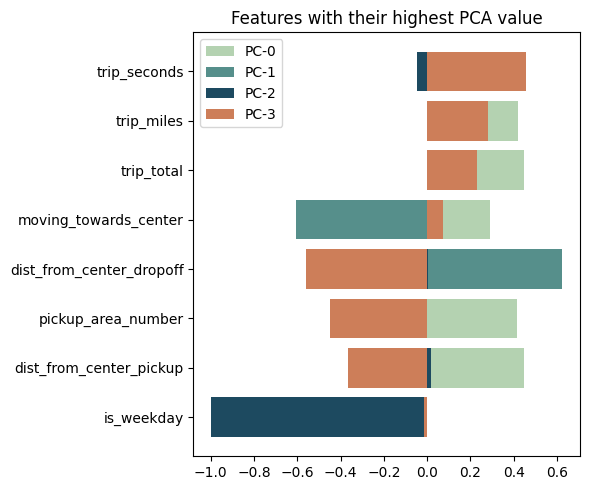

In [250]:
plt.figure(figsize=(6, 5))

# Plotting the explained variance ratios
features = df_selection.columns

# With scaling
for i in range(0, 4):
    plt.barh(features, pca_scaling.components_[i], label=f'PC-{i}', color=colors[i])
#plt.barh(features, pca_scaling.components_[1], label='PC-2', color=colors[1])
plt.title('Features with their highest PCA value')
plt.legend()

plt.tight_layout()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.06s/it]


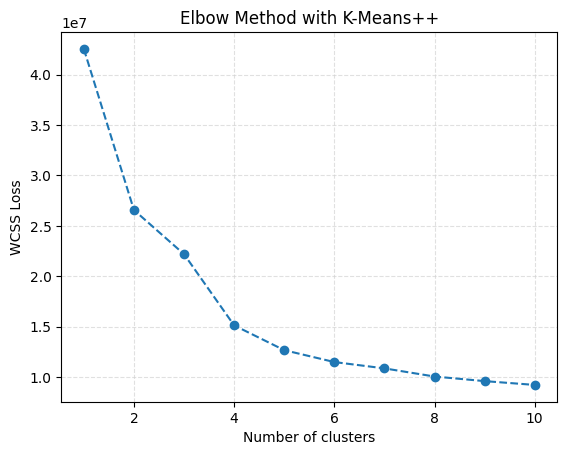

In [251]:
elbow_method(df_selection_scaled)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.17s/it]


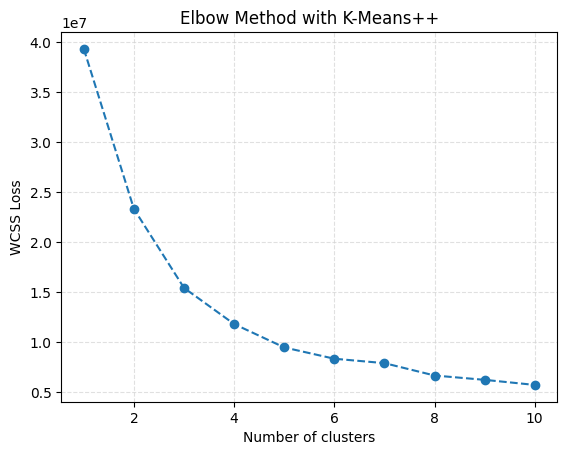

In [252]:
elbow_method(pca_scaling_result)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.51s/it]


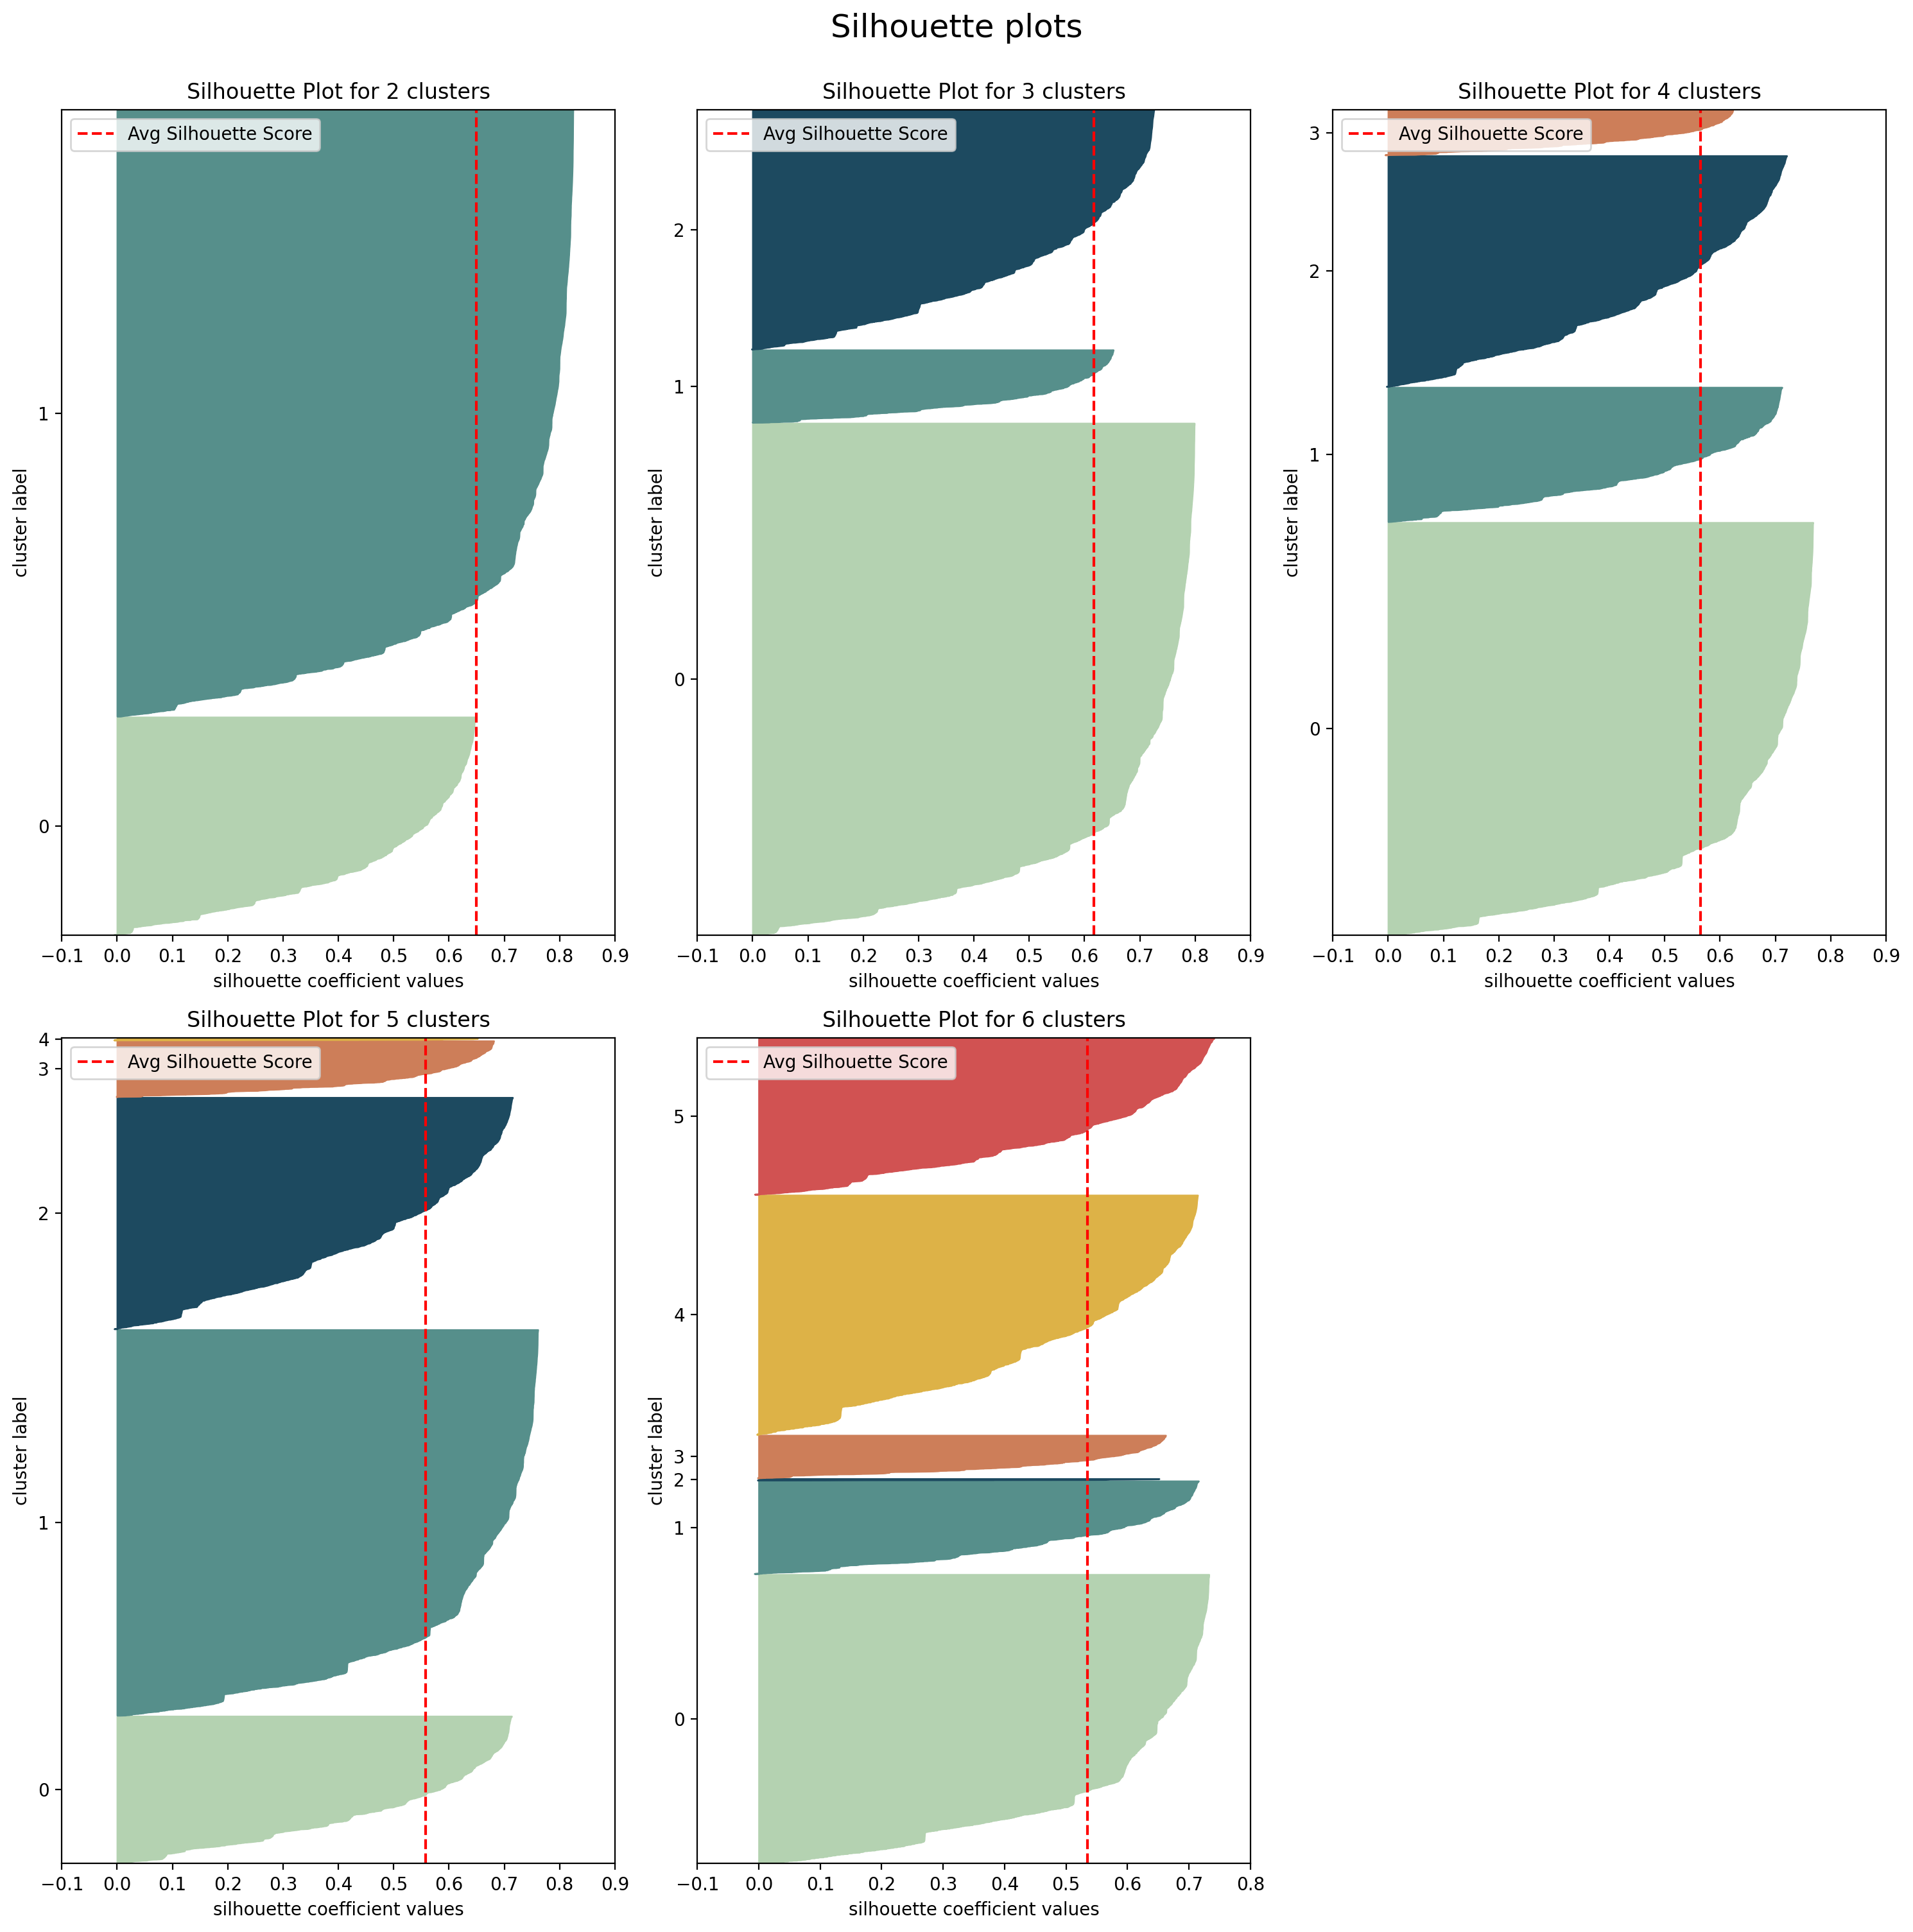

In [254]:
# Verify elbow method using silhouette scores
plot_silhouette_scores(df_selection, 6)

Based on the curve, we can see that the curve is smoothed from point "Number of cluster" = 4, indicating our elbow point. We additionally verify these results by comparing silhouette scores of kmeans++ for different cluster numbers. This, however, is only done for a small sample of the original dataframe **(10.000 entries)** since else silhouette scores are very computationally expensive to compute. We can see similar results for a cluster number of 4.  

In [266]:
# Set the max number of clusters for the following tasks
CLUSTER_NUMBER = 4

### 3.3 Clustering with kmeans++ and GMM

In [267]:
# Run kmeans++ (10 iterations)
kmeans = KMeans(n_clusters = CLUSTER_NUMBER, n_init=10, random_state=42)
df_selection['cluster_kmeans++'] = kmeans.fit_predict(df_selection_scaled)

C:\Users\25mad\AppData\Local\Temp\ipykernel_16964\249207790.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection['cluster_kmeans++'] = kmeans.fit_predict(df_selection_scaled)


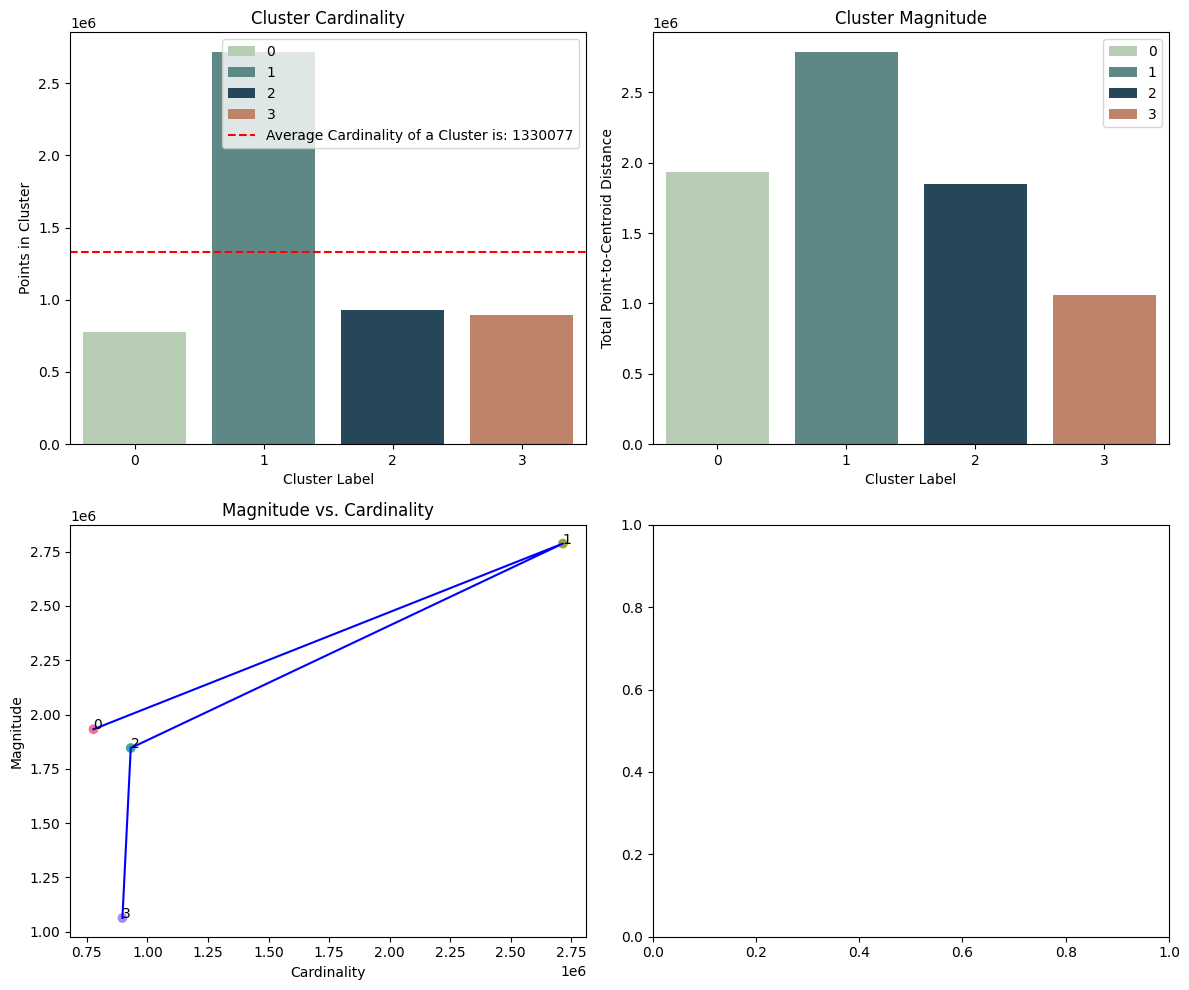

In [319]:
visualize_cluster_representative_power(CLUSTER_NUMBER, df_selection, 'cluster_kmeans++', kmeans.cluster_centers_, df_selection_scaled)

In [296]:
# kmeans++ with PCA 
kmeans_pca = KMeans(n_clusters = CLUSTER_NUMBER, n_init=10, random_state=42)
kmeans_pca.fit(pca_scaling_result)
cluster_labels = kmeans_pca.labels_

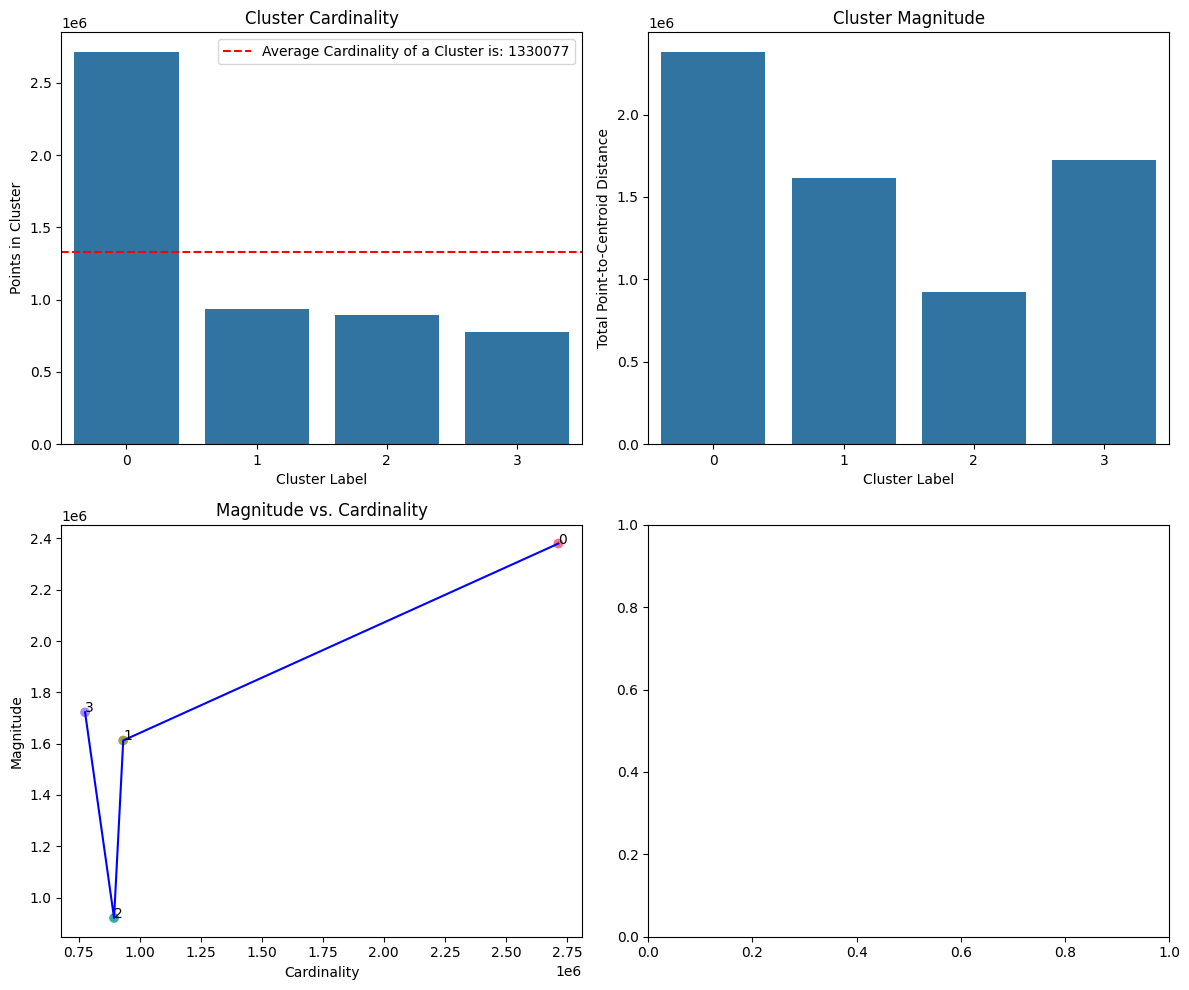

In [299]:
# Create a DataFrame from the PCA results
pca_df = pd.DataFrame(pca_scaling_result, columns=[f'PC{i+1}' for i in range(pca_scaling_result.shape[1])])
pca_df["cluster_kmeans++"] = kmeans_pca.labels_

visualize_cluster_representative_power(CLUSTER_NUMBER, pca_df, "cluster_kmeans++",kmeans_pca.cluster_centers_,pca_scaling_result)

In [300]:
# Run Gaussian Mixture Model
gmm = GaussianMixture(n_components = CLUSTER_NUMBER)
gmm.fit(df_selection_scaled)
df_selection["cluster_gmm"] = gmm.predict(df_selection_scaled)

C:\Users\25mad\AppData\Local\Temp\ipykernel_16964\3081145570.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection["cluster_gmm"] = gmm.predict(df_selection_scaled)


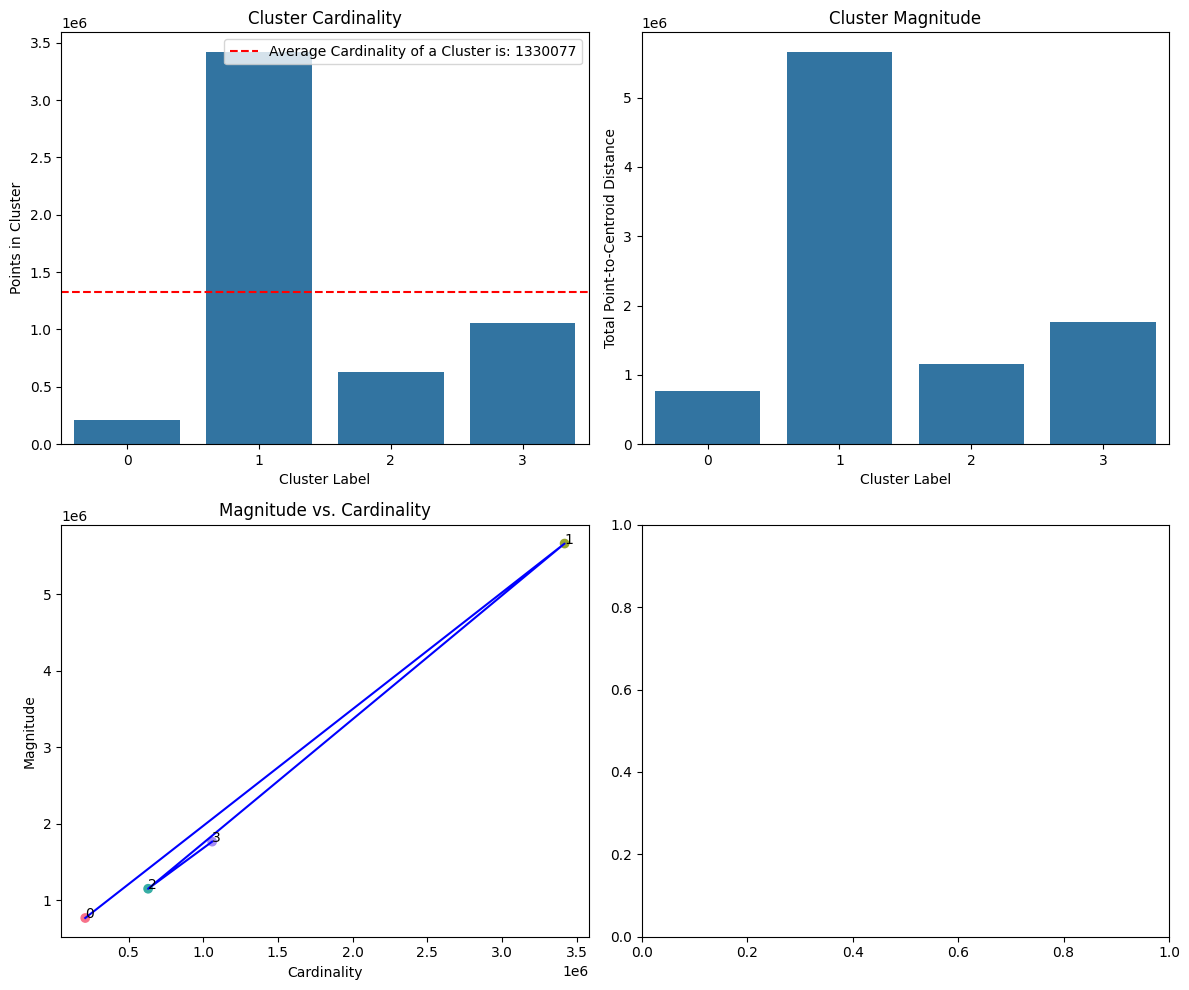

In [301]:
visualize_cluster_representative_power(CLUSTER_NUMBER, df_selection, 'cluster_gmm', kmeans.cluster_centers_, df_selection_scaled)

In [41]:
def plt_violins(dataframe):
        """
        Method to plot violin charts of the clustering results including a bar plot of the cluster sizes.
        """
 
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))

        fig, axes = plt.subplots(nrows = len(feature_cols) + 1, ncols = len(cluster_cols), figsize = (20,15))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                for feature_id, feat in enumerate(feature_cols):
                        sns.violinplot(ax = axes[feature_id, cluster_id], x=dataframe[cluster_col], y=dataframe[feat], data=dataframe)
                        axes[feature_id, cluster_id].set_title(f'{cluster_col} - {feat}')
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[len(feature_cols), cluster_id].bar(cluster_size.index, cluster_size)
                axes[len(feature_cols), cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()

### 5.0.2 Customer Based 